In [666]:
# Importing necessary libraries for data manipulation and analysis
import numpy as np
import pandas as pd
import datetime as dt

# Importing libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Importing libraries for clustering and data preprocessing
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Suppressing FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Ensuring that plots are displayed inline in the Jupyter notebook
%matplotlib inline

In [667]:
# Importing necessary library for data manipulation
import pandas as pd

def load_data(file_path):
    """
    This function loads an Excel file into a pandas DataFrame.

    Parameters:
    file_path (str): The path to the Excel file.

    Returns:
    DataFrame: The loaded data.
    """
    return pd.read_excel(file_path)

# Usage
file_path = "/Users/kaziamithasan/Desktop/Courses/Winter 24/CISC 839/A3/Online Retail.xlsx"
df = load_data(file_path)

In [668]:
df.shape


(541909, 8)

In [669]:
df.dtypes


InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [670]:
df.describe()


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Upon examining the 'Quantity' and 'Price' features, we observe the presence of negative values. These values suggest that some products were returned. Furthermore, a comparison between the 75th percentile and the maximum values reveals a significant disparity, indicating the existence of outliers in our dataset.

In [671]:
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [672]:
def print_unique_values(df):
    """
    This function prints the number of unique values in specified columns of a DataFrame.

    Parameters:
    df (DataFrame): The DataFrame to analyze.

    Returns:
    None
    """
    # Print the number of unique invoices
    print('A total of '+ str(df.InvoiceNo.nunique()) +' unique invoices in dataset.')

    # Print the number of unique products
    print( str(df.StockCode.nunique()) +' unique products in dataset.')

    # Print the number of unique customers
    print(str(df.CustomerID.nunique()) +' unique Customers in dataset.')

    # Print the number of unique countries
    print('Customers spread across '+ str(df.Country.nunique()) +' countries. ')

# Usage
print_unique_values(df)

A total of 25900 unique invoices in dataset.
4070 unique products in dataset.
4372 unique Customers in dataset.
Customers spread across 38 countries. 


# Data sanity check

Checking the null values in the dataset. Upon checking the null values, there's lot of customers without Customer ID.



In [673]:
df.isnull().sum().sort_values(ascending=False)


CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64


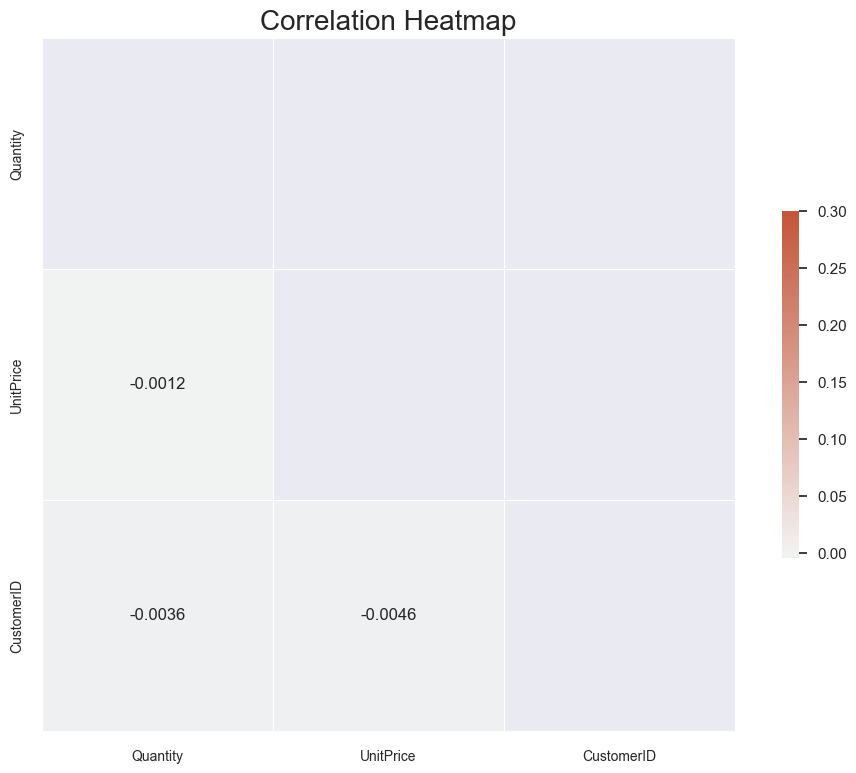

In [674]:
def plot_correlation_heatmap(df, cmap='coolwarm_r', annot=False):
    corrDf = df.corr()

    # Print the number of unique values for each column
    print(df.nunique())

    # Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
    mask = np.triu(np.ones_like(corrDf, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corrDf, mask=mask, cmap=cmap, annot=annot, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title('Correlation Heatmap', fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

# Usage
plot_correlation_heatmap(df, annot=True)

- The cell at the intersection of Quantity and UnitPrice shows a very small negative correlation (-0.0012). This suggests that there's almost no linear relationship between these two variables, but where it exists, it's slightly negative, implying that as quantity increases, unit price might decrease very slightly, and vice versa.

- The cell at the intersection of Quantity and CustomerID shows a negative correlation (-0.0036). This value is also very close to zero, indicating a negligible linear relationship between Quantity and CustomerID.





dropping rows which has negative quantity and price

In [675]:
df = df[(df['Quantity']>0) & (df['UnitPrice']>0)] 
df.describe()

,Quantity,UnitPrice,CustomerID
count,530104.000000,530104.000000,397884.000000
mean,10.542037,3.907625,15294.423453
std,155.524124,35.915681,1713.141560
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


In [676]:
df.shape

(530104, 8)

removing duplicated data from dataset.

In [677]:
df=df.drop_duplicates()
df.shape

(524878, 8)

The initial phase in constructing an RFM model involves attributing Recency, Frequency, and Monetary values to every customer. Therefore, RFM analysis can only be performed on customers who possess a customerID.

RFM Metrics Explained:

- Recency: This metric represents the duration since the customer's last transaction, measured in days.

- Frequency: This signifies the total count of transactions made by a customer.

- Monetary: This refers to the cumulative amount spent by the customer across all transactions.

To calculate the Recency value, we need to find the last invoice date.



In [678]:
df.InvoiceDate.max()


Timestamp('2011-12-09 12:50:00')

In [679]:
df.InvoiceDate.min()


Timestamp('2010-12-01 08:26:00')

In [680]:
# Create a column Amount(Total cost)
df['Amount'] = df['Quantity'] * df['UnitPrice']

In [681]:
import datetime as dt

def calculate_rfm(df, pin_date=dt.datetime(2011, 12, 10)):
    """
    This function calculates the Recency, Frequency, and Monetary value for each customer in a DataFrame.

    Parameters:
    df (DataFrame): The DataFrame to analyze.
    pin_date (datetime): The date to calculate recency .

    Returns:
    DataFrame: The DataFrame with the RFM values.
    """
    # Calculate RFM values
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda InvoiceDate: (pin_date - InvoiceDate.max()).days,
        'InvoiceNo': 'nunique',
        'Amount': 'sum'
    })

    # Rename the columns
    rfm.columns = ['recency', 'frequency', 'monetary']

    # Filter out rows where the monetary value is 0 or less
    rfm = rfm[rfm["monetary"] > 0]

    return rfm

# Usage
rfm = calculate_rfm(df)
rfm.head()

,recency,frequency,monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,18,1,1757.55
12350.0,310,1,334.40


Each customer needs to be assigned a score from 1 to 5 for recency, frequency, and monetary value.

The following describes the transformation of these columns into RFM scores ranging from 1 to 5, with '5' being the highest and '1' the lowest.

- For monetary value, a higher score of '5' is assigned to a higher value, indicating more spending.

- In terms of recency, a lower value signifies more recent purchases, thus it is given a higher score of '5'.

- Frequency follows the same pattern as monetary value; the more frequent the purchases, the higher the score.

In [682]:
def calculate_rfm_scores(rfm):
    """
    This function calculates the recency, frequency, and monetary scores for each customer in a DataFrame,
    and then calculates a total score.

    Parameters:
    rfm (DataFrame): The RFM DataFrame to analyze.

    Returns:
    DataFrame: The DataFrame with the RFM scores.
    """
    # Calculate recency score
    rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

    # Calculate frequency score
    rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

    # Calculate monetary score
    rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

    # Calculate total score
    rfm['score'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str) + rfm['monetary_score'].astype(str)

    return rfm

# Usage
rfm = calculate_rfm_scores(rfm)
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,score
CustomerID,,,,,,,
12346.0,325,1,77183.60,1,1,5,115
12347.0,2,7,4310.00,5,5,5,555
12348.0,75,4,1797.24,2,4,4,244
12349.0,18,1,1757.55,4,1,4,414
12350.0,310,1,334.40,1,1,2,112


We are dividing the customers into several categories to understand their characteristics.

- Champions: This category represents best customers who buy often and spend a lot. They are recent shoppers.
- Loyal Customers: Buy frequently but might not have made a purchase very recently or might not spend as much.
- Recent Customers: Have made a purchase recently but might not buy often or spend a lot.
- Potential Loyalists: Recent customers with relatively frequent purchases, indicating they're becoming more engaged.
- Big Spenders: Customers who spend the most, regardless of how recent or frequent their purchases are.
- At Risk: Were once frequent shoppers but haven’t made purchases recently.
- Can't Lose Them: High-value customers who have not made a purchase in a long time.
- Hibernating: Customers who haven't shopped in a long time and used to shop infrequently.
- Lost: The lowest engagement level across all RFM measures.

In [683]:
def categorize_rfm_scores(score):
    # High Value - Champions: High scores across all categories.
    if score >= '444':
        return 'Champions'
    # Loyal Customers: High frequency, regardless of recency and monetary value.
    elif score[1] == '5':
        return 'Loyal Customers'
    # Recent Customers: High recency score, regardless of frequency and monetary value.
    elif score[0] == '5':
        return 'Recent Customers'
    # Potential Loyalists: High recency and frequency, monetary value less important.
    elif score[:2] in ['45', '54']:
        return 'Potential Loyalists'
    # Big Spenders: High monetary value, regardless of recency and frequency.
    elif score[2] == '5':
        return 'Big Spenders'
    # At Risk: Customers who used to shop more frequently but haven't recently.
    elif score[0] in ['1', '2'] and score[1] in ['4', '5']:
        return 'At Risk'
    # Can't Lose Them: High overall value but haven't purchased for a long time.
    if score == '155':
        return 'Can\'t Lose Them'
    # Hibernating: Low recency and frequency, monetary value less important.
    elif score[0] in ['1', '2'] and score[1] in ['1', '2']:
        return 'Hibernating'
    # Lost: Low scores across all RFM categories.
    else:
        return 'Lost'

rfm['customer_segement'] = rfm['score'].apply(categorize_rfm_scores)

print(rfm[['score', 'customer_segement']].head())


           score customer_segement
CustomerID                        
12346.0      115      Big Spenders
12347.0      555         Champions
12348.0      244           At Risk
12349.0      414              Lost
12350.0      112       Hibernating


In [684]:
rfm

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,score,customer_segement
CustomerID,,,,,,,,
12346.0,325,1,77183.60,1,1,5,115,Big Spenders
12347.0,2,7,4310.00,5,5,5,555,Champions
12348.0,75,4,1797.24,2,4,4,244,At Risk
12349.0,18,1,1757.55,4,1,4,414,Lost
12350.0,310,1,334.40,1,1,2,112,Hibernating
...,...,...,...,...,...,...,...,...
18280.0,277,1,180.60,1,2,1,121,Hibernating
18281.0,180,1,80.82,1,2,1,121,Hibernating
18282.0,7,2,178.05,5,3,1,531,Champions


In [685]:
rfm['customer_segement'].value_counts()

Lost               1505
Champions          1269
Hibernating        1055
At Risk             185
Loyal Customers     184
Big Spenders        140
Name: customer_segement, dtype: int64

In [686]:
def aggregate_rfm_by_customer_segement(rfm):
    """
    This function groups an RFM DataFrame by 'level' and calculates the mean, min, and max for recency, frequency, and monetary.
    It also calculates the count for monetary.

    Parameters:
    rfm (DataFrame): The RFM DataFrame to analyze.

    Returns:
    DataFrame: The aggregated DataFrame.
    """
    # Group by 'level' and calculate aggregates
    aggregated_rfm = rfm.groupby('customer_segement').agg({
        'recency' : ['mean', 'min', 'max'],
        'frequency' : ['mean', 'min', 'max'],
        'monetary' : ['mean', 'min', 'max', 'count']
    })

    return aggregated_rfm

# Usage
aggregated_rfm = aggregate_rfm_by_customer_segement(rfm)
aggregated_rfm

recency          frequency              monetary  \
                         mean min  max      mean min  max         mean   
customer_segement                                                        
At Risk            139.978378  72  366  3.778378   3    5   936.808054   
Big Spenders        91.107143  14  336  3.385714   1    6  4340.542436   
Champions           10.805359   0   32  8.993696   1  209  4832.127147   
Hibernating        217.122275  72  373  1.096682   1    2   364.997072   
Lost                68.902326  14  373  2.136213   1    5   604.133603   
Loyal Customers     77.331522  33  372  8.554348   6   63  3695.440924   

                                             
                       min        max count  
customer_segement                            
At Risk             136.00    2011.88   185  
Big Spenders       2055.51   77183.60   140  
Champions            41.99  280206.02  1269  
Hibernating           3.75    2044.37  1055  
Lost                  6.20    2053.02  1505  
Loyal Customers      70.02   80850.84   184

# Analazying each segements

Champions: Champions: These are the best customers, who have made purchases very recently (mean recency of ~11 days), frequently (average frequency of almost 9 times), and have spent significantly (average monetary value of about $4832). Their spending ranges from $41.99 to an exceptional $280206.02. The large range in monetary values suggests that this group includes both regular and high-stakes spenders. This is the largest segment with 1269 customers. Company can design special offers for this category. 


At risk: Customers who have not made a purchase recently (mean recency of ~140 days), with their most recent purchase ranging from 72 to 366 days ago. They have a low to moderate purchase frequency (averaging about 3.78 times) and have spent an average of approximately $937, with individual expenditures ranging widely from $136 to $2011.88. There are 185 customers in this segment.

Big Spenders: Customers who have made purchases somewhat recently (mean recency of ~91 days) and with a frequency ranging from once to six times (average frequency of about 3.39). They are characterized by their high spending (average monetary value of roughly $4340), with individual amounts ranging from $2055.51 to an impressive $77183.60. This segment contains 140 customers.

Hibernating: Customers in this segment have been inactive for a considerable time (mean recency of ~217 days), with low purchase frequency (average of ~1.10 times), and lower spending (mean monetary value of approximately $365). The expenditures in this group range from $3.75 to $2044.37, indicating some variation in the amount spent when they do purchase. This segment includes 1055 customers.


Lost: These customers have an average recency similar to Big Spenders (mean of ~69 days), but their frequency (mean of ~2.14) and monetary values (mean of ~$604) are lower. The range of spending is quite broad, from $6.20 to $2053.02, which suggests variability in the amount they've spent historically. This is the second-largest segment with 1505 customers.


Loyal Customers: This segment represents highly frequent shoppers (mean frequency of ~8.55 times), who have made their most recent purchase within the last 33 to 372 days (mean recency of ~77 days). They also tend to spend a lot (mean monetary value of about $3695), with individual spending ranging from $70.02 to $80850.84. There are 184 customers in this segment.





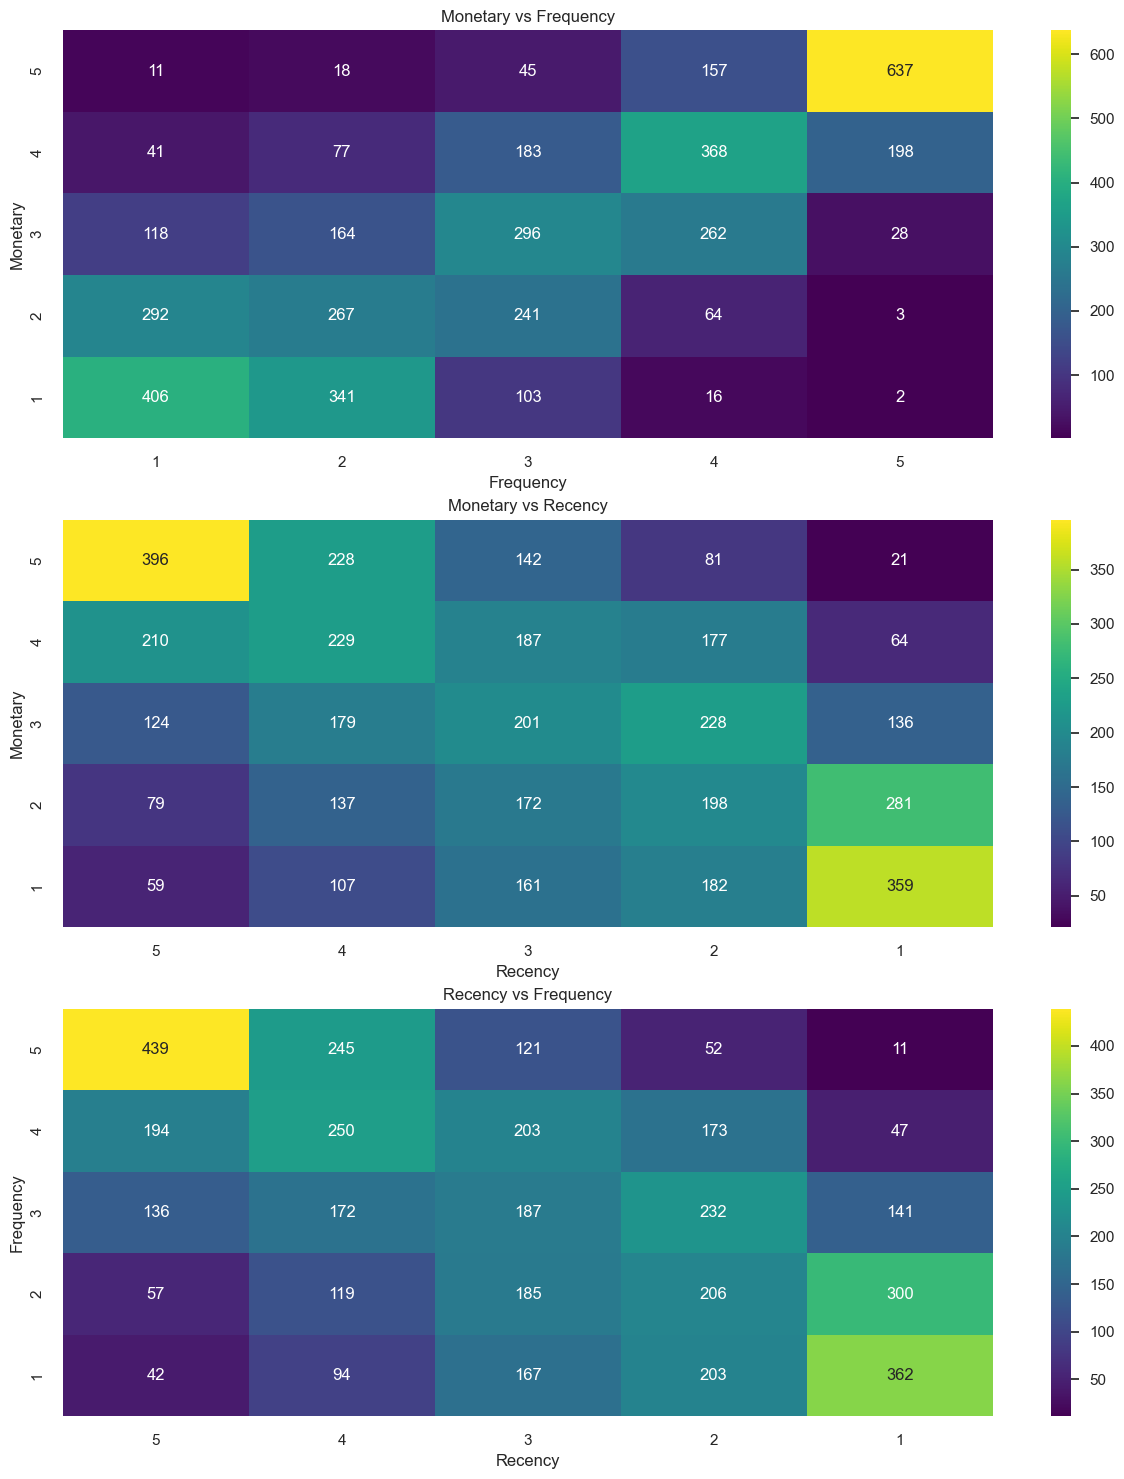

In [687]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_heatmaps(rfm):
    """
    This function creates three heatmaps: Monetary vs Frequency, Monetary vs Recency, and Recency vs Frequency.

    Parameters:
    rfm (DataFrame): The RFM DataFrame to analyze.

    Returns:
    None
    """
    # Create cross tables
    cross_table1 = pd.crosstab(index=rfm['monetary_score'], columns=rfm['frequency_score'])
    cross_table2 = pd.crosstab(index=rfm['monetary_score'], columns=rfm['recency_score'])
    cross_table3 = pd.crosstab(index=rfm['frequency_score'], columns=rfm['recency_score'])

    # Create a figure with 3 subplots
    plt.figure(figsize=(15,18))

    # Plot Monetary vs Frequency heatmap
    plt.subplot(311)
    ax1 = sns.heatmap(cross_table1, cmap='viridis', annot=True, fmt=".0f")
    ax1.invert_yaxis()
    ax1.set_ylabel('Monetary')
    ax1.set_xlabel('Frequency')
    ax1.set_title('Monetary vs Frequency')

    # Plot Monetary vs Recency heatmap
    plt.subplot(312)
    ax2 = sns.heatmap(cross_table2, cmap='viridis', annot=True, fmt=".0f")
    ax2.invert_yaxis()
    ax2.set_ylabel('Monetary')
    ax2.set_xlabel('Recency')
    ax2.set_title('Monetary vs Recency')

    # Plot Recency vs Frequency heatmap
    plt.subplot(313)
    ax3 = sns.heatmap(cross_table3, cmap='viridis', annot=True, fmt=".0f")
    ax3.invert_yaxis()
    ax3.set_ylabel('Frequency')
    ax3.set_xlabel('Recency')
    ax3.set_title('Recency vs Frequency')

    # Show the plot
    plt.show()

# Usage
plot_heatmaps(rfm)

In [688]:
# active = rfm[rfm['level'] == 'Active']
# average = rfm[rfm['level'] == 'Average']
# good = rfm[rfm['level'] == 'Good']
# inactive = rfm[rfm['level'] == 'Inactive']

# Clustering 
We plan to use unsupervised machine learning to categorize customers into distinct groups or clusters based on their purchasing patterns.

The formation of these clusters will be influenced by three key factors - recency, frequency, and monetary values of their purchases.

In [689]:
rfm.describe()


,recency,frequency,monetary
count,4338.000000,4338.000000,4338.000000
mean,92.059474,4.272015,2048.688081
std,100.012264,7.697998,8985.230220
min,0.000000,1.000000,3.750000
25%,17.000000,1.000000,306.482500
50%,50.000000,2.000000,668.570000
75%,141.750000,5.000000,1660.597500
max,373.000000,209.000000,280206.020000


## Checking outliers 

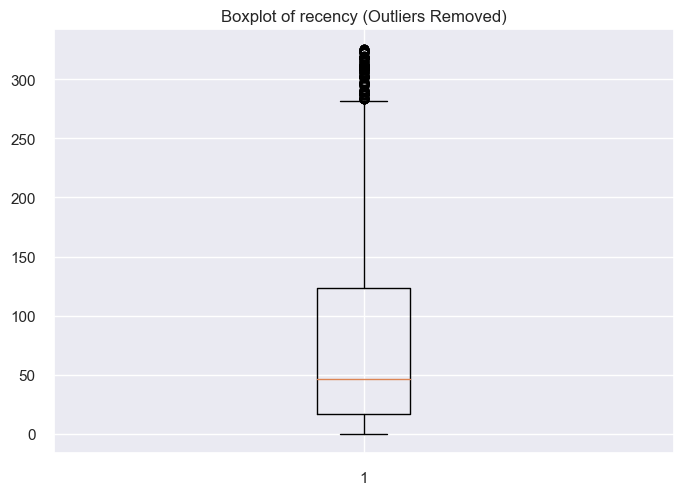

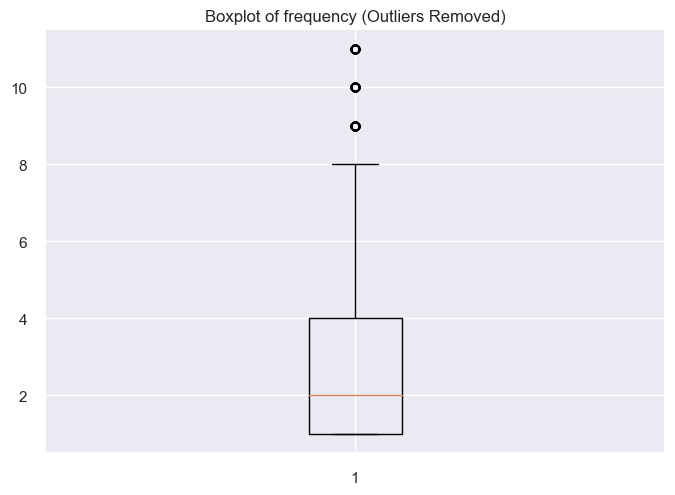

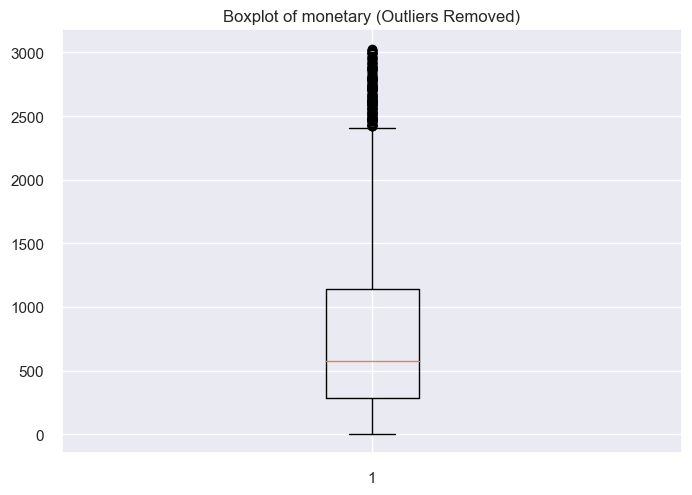

In [690]:
import matplotlib.pyplot as plt

def remove_outliers_and_plot(rfm, column):
    """
    This function removes outliers from a specified column of an RFM DataFrame using the IQR method,
    and then plots a boxplot of the cleaned data.

    Parameters:
    rfm (DataFrame): The RFM DataFrame to analyze.
    column (str): The column to clean and plot.

    Returns:
    DataFrame: The cleaned DataFrame.
    """
    # Calculate Q1, Q3, and IQR
    Q1 = rfm[column].quantile(0.25)
    Q3 = rfm[column].quantile(0.75)
    IQR = Q3 - Q1

    # Remove outliers
    rfm = rfm[(rfm[column] >= (Q1 - 1.5*IQR)) & (rfm[column] <= (Q3 + 1.5*IQR))]

    # Plot boxplot of cleaned data
    plt.boxplot(rfm[column])
    plt.title(f'Boxplot of {column} (Outliers Removed)')
    plt.show()

    return rfm

# Usage
rfm = remove_outliers_and_plot(rfm, 'recency')
rfm = remove_outliers_and_plot(rfm, 'frequency')
rfm = remove_outliers_and_plot(rfm, 'monetary')

In [691]:
rfm_selected = rfm[['recency', 'frequency', 'monetary']]

# K Means

In [692]:
from sklearn.preprocessing import StandardScaler

def scale_rfm_data(rfm):
    """
    This function scales the recency, frequency, and monetary columns of an RFM DataFrame using StandardScaler.

    Parameters:
    rfm (DataFrame): The RFM DataFrame to scale.

    Returns:
    ndarray: The scaled RFM data.
    """
    # Select the columns to scale
    #rfm_selected = rfm[['recency', 'frequency', 'monetary']]

    # Initialize a new StandardScaler instance
    scaler = StandardScaler()

    # Fit the scaler to the data and transform the data
    rfm_scaled = scaler.fit_transform(rfm_selected)

    return rfm_scaled

# Usage
rfm_scaled = scale_rfm_data(rfm)
rfm_scaled

array([[-0.18022534,  0.613312  ,  1.40888732],
       [-0.81740513, -0.83012059,  1.35221668],
       [ 2.44674396, -0.83012059, -0.67980198],
       ...,
       [ 0.9935269 , -0.83012059, -1.04187154],
       [-0.94036965, -0.3489764 , -0.90304347],
       [-0.5491189 ,  0.1321678 ,  1.4660577 ]])

Determining the number of clusters using Elbow method.



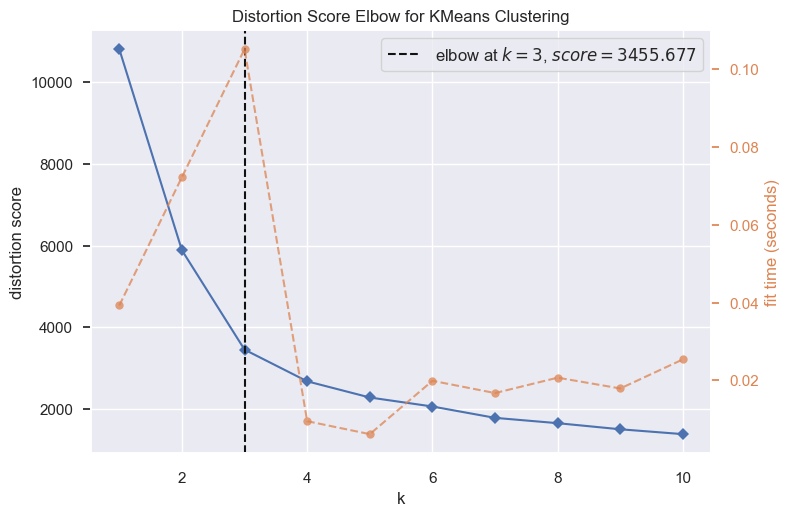

In [693]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

def visualize_elbow_method(data, k_range=(1,11)):
    """
    This function visualizes the elbow method for determining the optimal number of clusters for KMeans.

    Parameters:
    data (ndarray): The data to cluster.
    k_range (tuple): The range of k values to consider.

    Returns:
    None
    """
    # Initialize a new KMeans instance
    kmeans = KMeans()

    # Initialize a new KElbowVisualizer instance
    visualizer = KElbowVisualizer(kmeans, k=k_range)

    # Fit the visualizer to the data
    visualizer.fit(data)

    # Show the plot
    visualizer.show()

# Usage
visualize_elbow_method(rfm_scaled)

According to the Elbow method, the number of clusters is 3.



Our cluster centers are as follows:
[[-0.47053524 -0.33462153 -0.36235946]
 [-0.60857428  1.42579359  1.4762289 ]
 [ 1.52160461 -0.59431754 -0.58247001]]

Distribution of customers within each cluster (Ratio & Percentage):
Cluster 0: 1877 customers (0.52 ratio, 52.08% percentage)
Cluster 1: 819 customers (0.23 ratio, 22.72% percentage)
Cluster 2: 908 customers (0.25 ratio, 25.19% percentage)


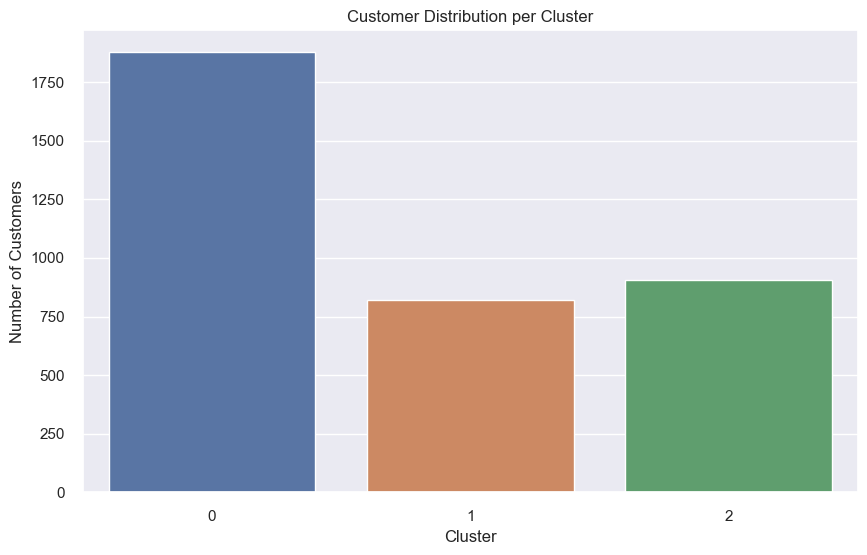

,recency,frequency,monetary,cluster_pred
CustomerID,,,,
12348.0,75,4,1797.24,1
12349.0,18,1,1757.55,0
12350.0,310,1,334.40,2
12352.0,36,8,2506.04,1
12353.0,204,1,89.00,2
...,...,...,...,...
18278.0,73,1,173.90,0
18280.0,277,1,180.60,2
18281.0,180,1,80.82,2


In [694]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def perform_kmeans_clustering(data, original_data, n_clusters=3):
    """
    This function performs KMeans clustering on the given data and adds the cluster predictions to the original data.
    It also prints the distribution of customers within each cluster as a ratio and percentage of the total customer count.

    Parameters:
    data (DataFrame): The data to cluster.
    original_data (DataFrame): The original DataFrame to add the cluster predictions to.
    n_clusters (int): The number of clusters to form.

    Returns:
    DataFrame: The original DataFrame with the cluster predictions added.
    """
    # Initialize a new KMeans instance
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    # Fit the KMeans instance to the data and predict the clusters
    kmeans.fit(data)
    cluster_predictions = kmeans.predict(data)

    # Copy the original DataFrame and add the cluster predictions
    clusters_df = original_data.copy()
    clusters_df['cluster_pred'] = cluster_predictions

    # Print the cluster centers
    print("Our cluster centers are as follows:")
    print(kmeans.cluster_centers_)

    # Calculate and print the distribution of customers within each cluster
    cluster_counts = clusters_df['cluster_pred'].value_counts().sort_index()
    total_customers = clusters_df.shape[0]
    print("\nDistribution of customers within each cluster (Ratio & Percentage):")
    for cluster, count in cluster_counts.items():
        ratio = count / total_customers
        percentage = ratio * 100
        print(f"Cluster {cluster}: {count} customers ({ratio:.2f} ratio, {percentage:.2f}% percentage)")

    # Plot a countplot of the cluster predictions
    sns.set(style="darkgrid")
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x="cluster_pred", data=clusters_df, order=sorted(clusters_df['cluster_pred'].unique()))
    ax.set_title("Customer Distribution per Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Customers")
    plt.show()

    return clusters_df


clusters_scaled = perform_kmeans_clustering(rfm_scaled, rfm_selected)
clusters_scaled


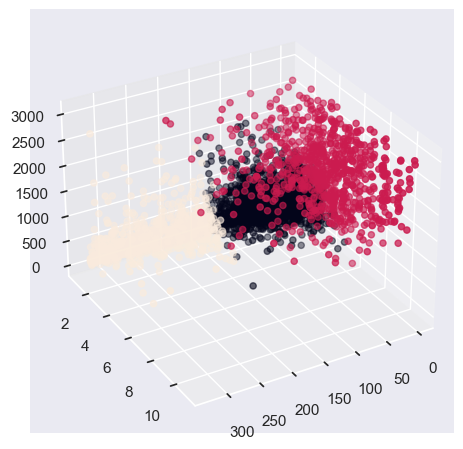

In [695]:
import matplotlib.pyplot as plt

def plot_3d_clusters(data, x='recency', y='frequency', z='monetary', c='cluster_pred'):
    """
    This function creates a 3D scatter plot of the given data.

    Parameters:
    data (DataFrame): The DataFrame to plot.
    x (str): The column to use for the x-axis.
    y (str): The column to use for the y-axis.
    z (str): The column to use for the z-axis.
    c (str): The column to use for the color of the points.

    Returns:
    None
    """
    # Create a new figure and a 3D subplot
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    # Extract the data to plot
    x_data = data[x]
    y_data = data[y]
    z_data = data[z]

    # Create a 3D scatter plot of the data
    ax.scatter3D(x_data, y_data, z_data, c=data[c])

    # Set the view angle
    ax.view_init(30, 60)

# Usage
plot_3d_clusters(clusters_scaled)

Silhouette Score: 0.453


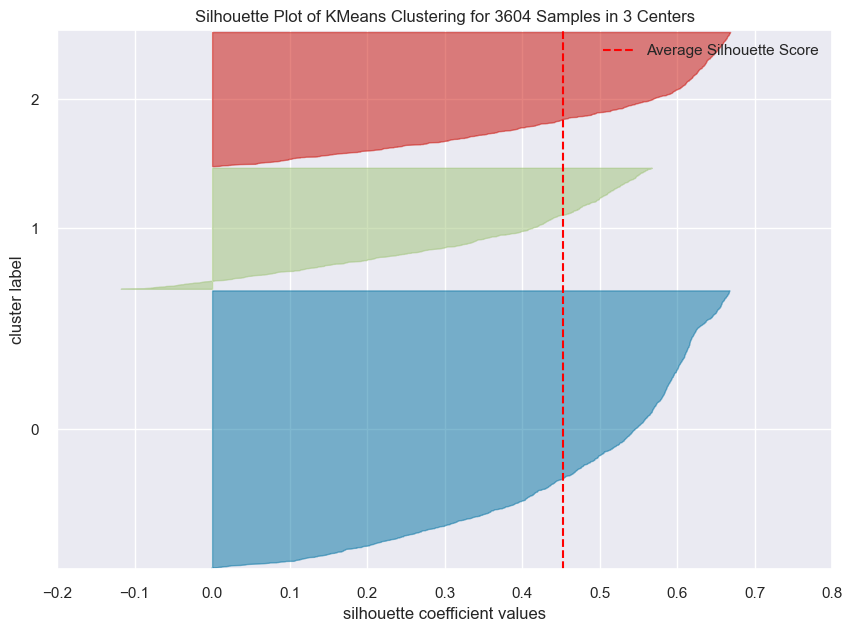

In [696]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import pandas as pd

def perform_kmeans_and_silhouette_analysis(data, original_data, n_clusters=3):
    """
    This function performs KMeans clustering on the given data, adds the cluster predictions to the original data,
    calculates the silhouette score, and visualizes the silhouette analysis.

    Parameters:
    data (DataFrame): The scaled data to cluster.
    original_data (DataFrame): The original DataFrame to add the cluster predictions to.
    n_clusters (int): The number of clusters to form.

    Returns:
    DataFrame: The original DataFrame with the cluster predictions added.
    """
    # Initialize a new KMeans instance
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    # Fit the KMeans instance to the data and predict the clusters
    cluster_predictions = kmeans.fit_predict(data)

    # Add the cluster predictions to the original DataFrame
    clusters_df = original_data.copy()
    clusters_df['cluster_pred'] = cluster_predictions

    # Calculate the silhouette score
    sil_score = silhouette_score(data, kmeans.labels_, metric='euclidean')
    print(f'Silhouette Score: {sil_score:.3f}')

    # Visualize the silhouette analysis
    plt.figure(figsize=(10, 7))
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(data)
    visualizer.show()

    return clusters_df

clusters_df = perform_kmeans_and_silhouette_analysis(rfm_scaled, rfm_selected, n_clusters=3)


# Cluster Profiling

In [697]:
# Add the predicted cluster labels to the original DataFrame
rfm_selected['cluster'] = clusters_scaled['cluster_pred']

# Copy the 'level' column from the original DataFrame to the new one
rfm_selected['customer_segement'] = rfm['customer_segement']

# Group the DataFrame by the 'cluster' column and calculate the mean, min, max, and count (for 'monetary' only) of each group
cluster_summary = rfm_selected.groupby('cluster').agg({
    'recency': ['mean', 'min', 'max'],
    'frequency': ['mean', 'min', 'max'],
    'monetary': ['mean', 'min', 'max', 'count']
})

# Display the summary statistics of each cluster
cluster_summary

/var/folders/49/199vrwcn1zqb7rx4rgy0xhbr0000gn/T/ipykernel_4357/601438417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_selected['cluster'] = clusters_scaled['cluster_pred']
/var/folders/49/199vrwcn1zqb7rx4rgy0xhbr0000gn/T/ipykernel_4357/601438417.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_selected['customer_segement'] = rfm['customer_segement']


recency           frequency             monetary                   \
               mean  min  max      mean min max         mean     min      max   
cluster                                                                         
0         49.029835    0  157  2.029835   1   6   556.724892    6.20  2062.06   
1         36.681319    0  235  5.688645   1  11  1844.403529  201.12  3029.87   
2        227.240088  129  326  1.490088   1   7   402.567676    3.75  2661.24   

               
        count  
cluster        
0        1877  
1         819  
2         908

## Cluster 0: Infrequent, Lower-Mid Value Customers

This cluster consists of the largest number of customers who have interacted with the business relatively recently (average recency of 49 days). They have interacted infrequently (on average just over 2 times) and spent a lower-mid range of money (average of approximately $557).

- Recency: Ranges from 0 (same day) to 157 days, suggesting a mix of new and slightly less active customers.
- Frequency: These customers have low to moderate purchase frequencies, with at least one purchase and no more than six.
- Monetary: The spending level is modest, with the lowest spenders at just over $6 and the highest just over $2062, indicating some willingness to spend.
- Size: The cluster is the largest with 1877 customers, representing a significant portion of the customer base.


## Cluster 1: Recently Engaged, Higher Value Customers
Customers in this cluster are more recent and frequent in their purchases than those in Cluster 0 and spend considerably more.
 
- Recency: The mean recency is about 37 days, with customers making purchases as recently as the same day and up to 235 days ago.

- Frequency: They purchase more often, with an average of nearly 5.7 times, indicating a pattern of returning customers.

- Monetary: This cluster has a higher average spend of roughly $1844, suggesting they contribute significantly to revenue.

- Size: Comprising 819 customers, it's a smaller group than Cluster 0 but may consist of some of the more valuable customers due to their higher spending and engagement.


## Cluster 2: Inactive, Lower Value Customers
These customers are the least active both in terms of recent interactions and purchase frequency, and they also spend less on average compared to other clusters.

- Recency: The average recency is 227 days, indicating that customers in this cluster have not made purchases recently and are at risk of churning.

- Frequency: The average frequency of 1.49 indicates a group that is largely composed of one-time or very infrequent buyers.

- Monetary: The average monetary value of about $403 places this group as the lowest in terms of spending.

- Size: With 908 customers, this cluster is smaller than Cluster 0 but larger than Cluster 1, representing a notable segment that may need re-engagement strategies.




The clustering analysis reveals varying levels of engagement and value across the customer base. Cluster 0, while not the most recent or frequent, includes the most customers and represents a moderate revenue stream. Cluster 1 shows customers that are engaged and valuable, with higher spending and frequency, making them key targets for retention and relationship building. Cluster 2 highlights a group that is largely inactive and spends the least, suggesting a need for re-engagement campaigns or exploratory analysis to understand their low activity. Tailoring marketing and customer relationship management strategies to the behaviors of each cluster can help in maximizing customer lifetime value and overall business profitability.














In [698]:
rfm_selected.groupby(['cluster','customer_segement']).size()


cluster  customer_segement
0        At Risk                77
         Big Spenders            1
         Champions             330
         Hibernating           258
         Lost                 1210
         Loyal Customers         1
1        At Risk                48
         Big Spenders           76
         Champions             494
         Lost                   97
         Loyal Customers       104
2        At Risk                59
         Big Spenders            1
         Hibernating           654
         Lost                  190
         Loyal Customers         4
dtype: int64

## Cluster 0: Infrequent, Lower-Mid Value Customers
Cluster 0 is the largest cluster and is characterized by relatively recent interactions with the business, infrequent transactions, and moderate spending.
RFM Segment Distribution:
Predominantly made up of 'Lost' customers (1210), suggesting many are at risk of churning despite recent engagement.
'Champions' (330) show that there is a solid core of customers who, despite infrequent purchases, are potentially loyal and valuable.
A significant number of 'Hibernating' customers (258) indicate a group that could be targeted to increase transaction frequency.
The presence of a few 'At Risk' (77) and very few 'Big Spenders' and 'Loyal Customers' (1 each) implies opportunities for targeted promotions to increase spend and loyalty.


## Cluster 1: Recently Engaged, Higher Value Customers
This cluster represents customers who are more engaged and valuable, with more frequent purchases and higher spending.
RFM Segment Distribution:
Dominated by 'Champions' (494), showing a strong base of highly engaged and potentially loyal customers.
A considerable number of 'Loyal Customers' (104) and 'Big Spenders' (76) underscore the higher value and loyalty within this group.
'At Risk' (48) customers may need immediate attention to retain their engagement level.
The smaller presence of 'Lost' customers (97) indicates a higher retention rate within this cluster.

## Cluster 2: Inactive, Lower Value Customers
Customers in this cluster are the least active and have the lowest average spend, indicating a segment with significant re-engagement potential.

RFM Segment Distribution:
A majority are 'Hibernating' (654), which reflects the cluster's overall lower activity and engagement.
'Lost' customers (190) are the second-largest segment, reinforcing the need for reactivation strategies within this cluster.
'At Risk' (59) customers may be on the verge of becoming 'Lost' or 'Hibernating' and could benefit from timely re-engagement initiatives.
The few 'Big Spenders' and 'Loyal Customers' (1 and 4, respectively) suggest that even among less active customers, there are opportunities to capitalize on their higher spending habits.


The clustering analysis provides a clear view of the customer base, segmenting them by activity, frequency, and spending levels. Cluster 0 contains a diverse mix of customers, with a large number at risk of churn but also a substantial base of 'Champions'. Cluster 1 is particularly valuable, with engaged customers who frequent and spend more, making them prime candidates for loyalty programs and exclusive offers. Cluster 2, while less active and spending the least, presents a significant opportunity for re-engagement and conversion strategies. Tailored engagement and retention strategies for each cluster will be crucial in maximizing revenue and ensuring a healthy customer lifecycle.







# Some observations

## Addressing Contradictions in Cluster 0's Composition:

Observation: The 'Champions' within Cluster 0 are engaging infrequently, which seems at odds with the typical definition of 'Champions' as recent, frequent, and high-spending customers.

Reasoning: It's possible that the 'Champions' in Cluster 0 have high monetary scores compensating for their lower frequency. This may reflect a purchasing pattern where customers make significant purchases in fewer transactions. Alternatively, this could indicate a recent change in customer behavior where previously frequent customers have become less so, yet their historical data still categorizes them as 'Champions.' It's also essential to consider the clustering algorithm's criteria, which might group customers based on a combination of factors, leading to more nuanced segments.

## Diverse Behaviors within Clusters:

Observation: Clusters contain a mix of RFM segments such as 'At Risk' and 'Champions,' suggesting complex behaviors that single RFM labels may not fully capture.

Reasoning: This diversity may be due to the multidimensional nature of customer behavior and the limitation of using three variables to capture this complexity. Customers may shift between segments over time, or the segments may overlap due to close scoring thresholds. A deeper analysis could reveal lifecycle stages or transaction patterns that explain the presence of different segments within the same cluster.

## 'Lost' Customers in Cluster 1:
Observation: 'Lost' customers are present in Cluster 1, which is otherwise characterized by recent and frequent purchases.

Reasoning: The 'Lost' customers in Cluster 1 could be recent one-time purchasers with high monetary value who have not returned. Their classification as 'Lost' could be premature if not enough time has passed to observe their potential for repeat purchases. This underlines the dynamic nature of customer engagement and the need for a time-sensitive approach to segmentation.

## Cluster 2's 'Big Spenders' and 'Loyal Customers':


Observation: Despite being labeled as inactive and lower value, Cluster 2 includes 'Big Spenders' and 'Loyal Customers.'

Reasoning: This could occur if the cluster contains a few high-value transactions that are not recent or frequent enough to shift the overall cluster average but still qualify under the 'Big Spenders' criteria. As for 'Loyal Customers,' they may have been frequent in the past but have not made recent purchases, reflecting a need to update the segmentation model to account for changes in customer behavior over time.







In [699]:
from sklearn.preprocessing import StandardScaler

# Create a copy of the original DataFrame
rfm_scaled = rfm_selected.copy()

# Initialize a new StandardScaler instance
scaler = StandardScaler()

# Scale the 'recency', 'frequency', and 'monetary' columns of the DataFrame
rfm_scaled[['recency', 'frequency', 'monetary']] = scaler.fit_transform(rfm_scaled[['recency', 'frequency', 'monetary']])

# Add the index of the original DataFrame as a new column in the scaled DataFrame
rfm_scaled['CustomerID'] = rfm_selected.index
rfm_scaled

,recency,frequency,monetary,cluster,customer_segement,CustomerID
CustomerID,,,,,,
12348.0,-0.180225,0.613312,1.408887,1,At Risk,12348.0
12349.0,-0.817405,-0.830121,1.352217,0,Lost,12349.0
12350.0,2.446744,-0.830121,-0.679802,2,Hibernating,12350.0
12352.0,-0.616190,2.537889,2.420934,1,Loyal Customers,12352.0
12353.0,1.261813,-0.830121,-1.030192,2,Hibernating,12353.0
...,...,...,...,...,...,...
18278.0,-0.202583,-0.830121,-0.908969,0,Hibernating,18278.0
18280.0,2.077850,-0.830121,-0.899402,2,Hibernating,18280.0
18281.0,0.993527,-0.830121,-1.041872,2,Hibernating,18281.0


In [700]:
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['CustomerID', 'customer_segement', 'cluster'], var_name = 'metrics', value_name = 'value')
rfm_melted.head()

,CustomerID,customer_segement,cluster,metrics,value
0,12348.0,At Risk,1,recency,-0.180225
1,12349.0,Lost,0,recency,-0.817405
2,12350.0,Hibernating,2,recency,2.446744
3,12352.0,Loyal Customers,1,recency,-0.616190
4,12353.0,Hibernating,2,recency,1.261813
